1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [2]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [5]:
working = '../data/working'

In [6]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [193]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [194]:
# targets['eos']['box'] = targets['eos']['box'][5:6]
# targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
# targets['eos']['temp'] = targets['eos']['temp'][5:6]
# targets['eos']['beta'] = targets['eos']['beta'][5:6]
# targets['eos']['energy'] = targets['eos']['energy'][5:6]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [195]:
targets['eos']['box'] = targets['eos']['box'][6:7]
targets['eos']['xyz'] = targets['eos']['xyz'][6:7]
targets['eos']['temp'] = targets['eos']['temp'][6:7]
targets['eos']['beta'] = targets['eos']['beta'][6:7]
targets['eos']['energy'] = targets['eos']['energy'][6:7]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][6:7]

In [196]:
# targets['eos']['box'] = targets['eos']['box'][4:5]
# targets['eos']['xyz'] = targets['eos']['xyz'][4:5]
# targets['eos']['temp'] = targets['eos']['temp'][4:5]
# targets['eos']['beta'] = targets['eos']['beta'][4:5]
# targets['eos']['energy'] = targets['eos']['energy'][4:5]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][4:5]

In [197]:
# targets['eos']['box'] = targets['eos']['box'][4:6]
# targets['eos']['xyz'] = targets['eos']['xyz'][4:6]
# targets['eos']['temp'] = targets['eos']['temp'][4:6]
# targets['eos']['beta'] = targets['eos']['beta'][4:6]
# targets['eos']['energy'] = targets['eos']['energy'][4:6]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][4:6]

In [198]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [199]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:6]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:6]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:6]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:6]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:6]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:6]

In [200]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [201]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [202]:
np.linspace(1.05, 4.25, 5)

array([1.05, 1.85, 2.65, 3.45, 4.25])

In [203]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.25, 33))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [204]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [205]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [206]:
len(pair_knots), len(edens_knots)

(43, 33)

In [207]:
# #scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
# #[(s, k) for s, k in zip(scale, pair_knots)]


# # 3rd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, scale, [], []])
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp3, Cp3, c3 = penalty_matrix(partitions)
# print(c3, Cp3, Dp3[:])

# # 2nd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp2, Cp2, c2 = penalty_matrix(partitions)
# Dp3.shape, Dp2.shape

In [208]:
def make_input_matrices(target, stats, keytrj=None, combined=0.0):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    max_features = 0
    max_atoms = 0
    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)

        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            #weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append(slice(lo_bound, len(y), 1))
        weights.append(w)
    
    if combined > 0.0:
        # add trajectory of zeros by replicating 'inf'
        
        config = stats['inf']['energy'][0]
        energy = target['inf']['energy'][0]
        bb = target['inf']['beta'][0]
        
        for i in range(200):
            # add energy
            y.append(energy)
            beta.append(bb)
            #weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append(slice(0, len(y), 1))
        weights.append(combined)

    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    
    print('bounds', bounds)
    print('weights', weights)

    return X, y, np.array(weights), np.array(beta), bounds

In [209]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [210]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 1.0
targets['relax']['weight'] = 100.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 2.0
targets['bcc_npt_langevin_3700K']['weight'] = 2.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 2.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 100.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 2.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 1.0),
 ('bain', 0.1)]

In [211]:
targets['eos']['temp'][0] = 5000.0

## Start with preoptimized parameters obtained from an additive model

In [212]:
def _tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [213]:
#edens_coeffs = _tpf_to_bspline(len(edens_knots)*8+1)[8::8]
edens_coeffs = _tpf_to_bspline(len(edens_knots))
edens_coeffs

array([6.545e+03, 5.984e+03, 5.456e+03, 4.960e+03, 4.495e+03, 4.060e+03,
       3.654e+03, 3.276e+03, 2.925e+03, 2.600e+03, 2.300e+03, 2.024e+03,
       1.771e+03, 1.540e+03, 1.330e+03, 1.140e+03, 9.690e+02, 8.160e+02,
       6.800e+02, 5.600e+02, 4.550e+02, 3.640e+02, 2.860e+02, 2.200e+02,
       1.650e+02, 1.200e+02, 8.400e+01, 5.600e+01, 3.500e+01, 2.000e+01,
       1.000e+01, 4.000e+00, 1.000e+00])

In [214]:
b_preoptimized = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]

b_preoptimized = [
    -2.25564987e-01,  5.53471774e-05,  2.25541375e+03,  1.87319444e+03,
        1.52245661e+03,  1.20320028e+03,  9.15425419e+02,  6.59132036e+02,
        4.34320116e+02,  2.40989652e+02,  7.91406346e+01, -5.12269452e+01,
       -1.50194991e+02, -2.18597091e+02, -2.58686101e+02, -2.74078279e+02,
       -2.69861457e+02, -2.53982776e+02, -2.36493980e+02, -2.19246225e+02,
       -2.00531784e+02, -1.79009846e+02, -1.55497117e+02, -1.32694786e+02,
       -1.11402428e+02, -9.23235147e+01, -7.65468525e+01, -6.42617727e+01,
       -5.51831766e+01, -4.82737014e+01, -4.21720863e+01, -3.60158538e+01,
       -3.01743175e+01, -2.53604141e+01, -2.05869266e+01, -1.60165503e+01,
       -1.35593001e+01, -1.01858959e+01, -4.77285549e+00,  1.66505117e-01,
        9.71591796e-01, -1.81329966e+00, -3.46311117e+00, -3.49135492e+00,
       -1.67856521e+00
]

b_preoptimized = [
    -8.62142614e-01,  5.76185952e-04,  2.60678195e+03,  2.21333078e+03,
        1.85091762e+03,  1.51954248e+03,  1.21920534e+03,  9.49906210e+02,
        7.11645092e+02,  5.04421987e+02,  3.28236896e+02,  1.83089821e+02,
        6.89200289e+01, -1.49069956e+01, -7.02022078e+01, -1.00158659e+02,
       -1.09874134e+02, -1.07862489e+02, -1.04183739e+02, -1.00154277e+02,
       -9.34934573e+01, -8.31140399e+01, -7.01324477e+01, -5.73733960e+01,
       -4.53998654e+01, -3.46167922e+01, -2.61191305e+01, -2.03448417e+01,
       -1.72869419e+01, -1.60760416e+01, -1.53674281e+01, -1.43398461e+01,
       -1.31226750e+01, -1.20232162e+01, -1.02405430e+01, -8.15803964e+00,
       -7.81912304e+00, -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,
        1.43191260e+00, -1.97196751e+00, -3.93012775e+00, -3.71908056e+00,
       -1.84930892e+00
]

b_preoptimized = [
    -6.46003130e-01,  7.85871765e-06,  3.15534395e+03,  2.72378871e+03,
        2.32544531e+03,  1.96031377e+03,  1.62839421e+03,  1.32968680e+03,
        1.06419176e+03,  8.31909330e+02,  6.32839739e+02,  4.66983207e+02,
        3.34151254e+02,  2.32472926e+02,  1.57536663e+02,  1.05204064e+02,
        7.31617109e+01,  5.38645680e+01,  3.79930283e+01,  2.99543510e+01,
        2.32950333e+01,  1.64820307e+01,  1.47930684e+01,  1.67083553e+01,
        2.10947563e+01,  2.51714433e+01,  2.78784388e+01,  3.06791356e+01,
        2.94699342e+01,  2.42869002e+01,  1.85732752e+01,  1.30728769e+01,
        7.63359417e+00,  3.78059718e+00,  3.76799965e+00,  2.91392821e+00,
       -1.27624188e+00, -5.36468372e-01,  2.67239460e+00,  4.31532027e+00,
        3.50631260e+00,  1.49947121e+00, -1.21790753e+00, -1.15964733e+00,
        1.73779893e+00
]
b_preoptimized = [-1.48890852e+00, -1.89656567e-05,  4.11114713e+03,  3.58184960e+03,
        3.09167632e+03,  2.64062730e+03,  2.22870265e+03,  1.85590254e+03,
        1.52222715e+03,  1.22767670e+03,  9.72251390e+02,  7.55951430e+02,
        5.78574263e+02,  4.38099916e+02,  3.29632933e+02,  2.48189331e+02,
        1.90466442e+02,  1.47865787e+02,  1.11018748e+02,  8.52153708e+01,
        6.34305903e+01,  4.32409477e+01,  3.03354436e+01,  2.31374883e+01,
        2.03110469e+01,  1.87632212e+01,  1.72027393e+01,  1.73033627e+01,
        1.47715464e+01,  8.99940928e+00,  3.38195294e+00, -1.53465249e+00,
       -5.89727312e+00, -8.08220252e+00, -6.00115971e+00, -4.52578517e+00,
       -6.76564604e+00, -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,
        2.45383322e+00,  7.47619823e-01, -1.59126609e+00, -1.18099220e+00,
        1.83761329e+00]

In [215]:
# Rescale initial parameters
Ae, Be = b_preoptimized[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Be] + list(b_preoptimized[2:]) + list(edens_coeffs))
b_init

array([-3.85918701e-06,  4.11114713e+03,  3.58184960e+03,  3.09167632e+03,
        2.64062730e+03,  2.22870265e+03,  1.85590254e+03,  1.52222715e+03,
        1.22767670e+03,  9.72251390e+02,  7.55951430e+02,  5.78574263e+02,
        4.38099916e+02,  3.29632933e+02,  2.48189331e+02,  1.90466442e+02,
        1.47865787e+02,  1.11018748e+02,  8.52153708e+01,  6.34305903e+01,
        4.32409477e+01,  3.03354436e+01,  2.31374883e+01,  2.03110469e+01,
        1.87632212e+01,  1.72027393e+01,  1.73033627e+01,  1.47715464e+01,
        8.99940928e+00,  3.38195294e+00, -1.53465249e+00, -5.89727312e+00,
       -8.08220252e+00, -6.00115971e+00, -4.52578517e+00, -6.76564604e+00,
       -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,  2.45383322e+00,
        7.47619823e-01, -1.59126609e+00, -1.18099220e+00,  1.83761329e+00,
        1.45092740e+04,  1.32656219e+04,  1.20951259e+04,  1.09955690e+04,
        9.96473437e+03,  9.00040524e+03,  8.10036471e+03,  7.26239595e+03,
        6.48428210e+03,  

## SD matching
**Loss function**

In [216]:
def energy(params, X):
    """ Configurational energy of an EAM model.
    """
    
    n_edens = X[1].shape[-1]
    
    # Pair energy
    energy = X[0].dot(params[1:-n_edens])
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    edens = X[1].dot(params[-n_edens:])

    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy += -1.0*np.sum(np.sqrt(edens), axis=1)
    energy += params[0]*np.sum(edens**2, axis=1)
        
    return energy

In [217]:
def loss_energy(params, X, y, weights):
    """Total energy loss (least squares)"""

    du = y - energy(params, X)
    loss = du.T.dot(np.diag(weights)).dot(du)

    return loss

In [218]:
def loss_sd2(params, X, y, weights, bounds, beta):
    """Statistical distance loss"""

    beta_du = beta*(y - energy(params, X))

    # statistical distance
    # * divide system into individual trajectories (use bounds)
#     loss = 0.0
#     for ib, x_lo, x_hi in enumerate(bounds):
#         uuu = beta_du[x_lo:x_hi]
#         uuu -= np.mean(uuu)
#         eee = np.exp(-uuu)
#         ge = np.log(np.mean(eee))              # -beta*dF
#         cb = np.mean(np.exp(-0.5*(uuu + ge)))  # Bhattacharyya coefficient
#         loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    loss = 0.0
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]             # du (view of the original beta*du)
        du_ave = np.mean(du)                   # average du
        exp_duh = np.exp(-0.5*(du - du_ave))     # exp[-beta*du/2]
        cb = np.mean(exp_duh)                    # cb = <exp[-beta*du/2]>
        cb /= np.sqrt(np.mean(exp_duh**2))       # Bhattacharyya coeff.: cb/exp[-beta*dF/2]
        #print('loss cb', cb)
        loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    return loss

In [219]:
def loss_diff_penalty(params, penalty_mat, alpha):
    """Difference penalty loss for B-splines"""
    return 0.5*alpha*params.T.dot(penalty_mat).dot(params)

In [220]:
#def loss_total(params, X, y, weights, args=None):

In [221]:
def loss_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    """Total energy loss with difference penalty"""

    loss = loss_energy(params, X, y, weights)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)
    
    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

In [222]:
def loss_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    """Total sd2 loss with difference penalty"""
    
    loss = loss_sd2(params, X, y, weights, bounds, beta)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)

    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

**Jacobian calculation**

In [223]:
def gradient_energy(params, X):
    """Calculates gradient of energy with respect to parameters.
    
    Returns
    -------
    grad : ndarray, shape (N, p)
    """

    # electronic densities
    n_edens = X[1].shape[-1]
    edens = X[1].dot(params[-n_edens:])
    
    with np.errstate(divide='ignore'):
        # (-1) is there for the constant parameter value
        tmp = np.nan_to_num(-1.0/(2.0*np.sqrt(edens)) + 2.0*params[0]*edens)

    grad = np.empty((X[0].shape[0], len(params)), dtype=float)
    grad[:, 1:-n_edens] = X[0]                                 # pair
    grad[:, 0] = np.sum(edens**2, axis=1)                      # embed
    grad[:, -n_edens:] = np.sum(tmp[:, :, None]*X[1], axis=1)  # edens

    return grad

In [224]:
def jacobian_energy(params, X, y, weights):
    """Calculates jacobian of energy loss function"""
    
    du = y - energy(params, X)
    grad = gradient_energy(params, X)
    jac = -2.0*grad.T.dot(np.diag(weights)).dot(du)
    
    return jac

In [225]:
def jacobian_sd2(params, X, y, weights, bounds, beta):
    """Calculates jacobian of statistical distance loss function"""
    
    # use reduced units beta*energy throughout
    beta_du = beta*(y - energy(params, X))                    # shape (N,)
    grad_beta_du = beta[:, np.newaxis]*gradient_energy(params, X)  # shape (N, p)

    jac = np.zeros((len(params)), dtype=float)
    
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]               # du (view of the original beta*du)
        du_ave = np.mean(du)                    # average du
        exp_duh = np.exp(-0.5*(du - du_ave))    # exp[-beta*du/2]
        exp_du = exp_duh**2                     # exp[-beta*du]
        exp_dfi = 1.0/np.mean(exp_du)           # 1/<exp[-beta*du]> = exp(beta*dF)
        cb = np.mean(exp_duh)*np.sqrt(exp_dfi)  # Bhattacharyya coefficient
        #print('jac cb', cb)

        # Gradient of free energy (with respect to model parameters)
        # grad_df = <grad_beta_du * exp[-beta*du]> / <exp[-beta*du]>
        grad_du = grad_beta_du[bound_slice]
        grad_df = np.mean(grad_du*exp_du[:, None], axis=0)*exp_dfi
        
        # Gradient of the Bhattacharyya coeff. shape (p,)
        # -1/2 * <exp[-beta*du/2] * (grad_beta_du - grad_df)> / exp[-beta*df/2]
        grad_cb = np.mean((grad_du - grad_df[None, :])*exp_duh[:, None], axis=0)
        grad_cb *= -0.5*np.sqrt(exp_dfi)
        
        # Jacobian
        jac += -2.0*weights[ib]*np.arccos(cb)/np.sqrt(1.0 - cb**2)*grad_cb
    
    return jac

In [226]:
def jacobian_diff_penalty(params, penalty_mat, alpha):
    """Jacobian contribution of the B-spline difference penalty"""
    return alpha*penalty_mat.dot(params)

In [227]:
def jacobian_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    jac = jacobian_energy(params, X, y, weights)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [228]:
def jacobian_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    jac = jacobian_sd2(params, X, y, weights, bounds, beta)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [229]:
# b_init = np.array([ 2.15039091e-04,  2.39583735e+03,  2.06488126e+03,  1.75850009e+03,
#         1.47669328e+03,  1.21946137e+03,  9.86807244e+02,  7.78732277e+02,
#         5.95235136e+02,  4.36312752e+02,  3.01965422e+02,  1.92143407e+02,
#         1.06323715e+02,  4.32286398e+01,  1.72198297e+00, -1.96841385e+01,
#        -2.78317473e+01, -3.23254722e+01, -3.12921167e+01, -2.87148042e+01,
#        -2.60682284e+01, -1.97964742e+01, -1.05483048e+01, -6.91446618e-02,
#         9.80600312e+00,  1.81497062e+01,  2.44762828e+01,  2.59117419e+01,
#         2.29637333e+01,  1.81441067e+01,  1.21450205e+01,  5.90203739e+00,
#         1.68875805e+00,  9.29697477e-02, -1.94775719e+00, -5.14555395e+00,
#        -3.34783032e+00, -8.46442656e-02,  1.78474570e+00,  2.09831830e+00,
#         1.03026931e+00, -1.72104174e+00, -1.47551091e+00,  1.24247691e+00,
#         5.33214477e+03,  4.84692005e+03,  4.39079702e+03,  3.96377336e+03,
#         3.56584285e+03,  3.19699904e+03,  2.85723735e+03,  2.54655515e+03,
#         2.26495051e+03,  2.01241801e+03,  1.78894026e+03,  1.59440068e+03,
#         1.42843437e+03,  1.29019037e+03,  1.17803243e+03,  1.08943679e+03,
#         1.02111648e+03,  9.68845779e+02,  9.28176227e+02,  8.94286865e+02,
#         8.62207834e+02,  8.27644481e+02,  7.87304159e+02,  7.39142252e+02,
#         6.82278709e+02,  6.16822322e+02,  5.43748998e+02,  4.64539444e+02,
#         3.81083191e+02,  2.95624418e+02,  2.10263603e+02,  1.26317261e+02,
#         4.42271600e+01])
# b_init = np.array([ 2.43999106e-04,  2.52128493e+03,  2.15488886e+03,  1.82533635e+03,
#         1.53263567e+03,  1.27328473e+03,  1.04327275e+03,  8.38227850e+02,
#         6.54702153e+02,  4.90338815e+02,  3.45310767e+02,  2.21650715e+02,
#         1.22344038e+02,  4.86979947e+01, -2.43504074e-02, -2.62455113e+01,
#        -3.61565798e+01, -3.86147942e+01, -4.00143579e+01, -3.74077905e+01,
#        -2.83261890e+01, -1.58581456e+01, -6.31067731e+00, -1.16989909e-01,
#         7.79223897e+00,  1.72826882e+01,  2.64433060e+01,  3.25003999e+01,
#         3.29484166e+01,  2.74761068e+01,  1.87495268e+01,  1.02691487e+01,
#         4.15265797e+00, -4.77963046e-02, -1.53882618e+00, -9.51994167e-01,
#        -1.71004974e-01, -2.64667027e-01, -1.09556210e+00,  7.74236484e-02,
#         1.16083191e-01, -1.85103742e+00, -4.77867098e-01, -4.82654826e-02,
#         5.34595572e+03,  4.86636174e+03,  4.41499178e+03,  3.99197512e+03,
#         3.59715483e+03,  3.22998825e+03,  2.89023528e+03,  2.57840408e+03,
#         2.29490404e+03,  2.04138285e+03,  1.81944558e+03,  1.62861946e+03,
#         1.46706508e+03,  1.33180748e+03,  1.22022385e+03,  1.12999952e+03,
#         1.05876348e+03,  1.00349486e+03,  9.60239382e+02,  9.24364045e+02,
#         8.91372814e+02,  8.57311443e+02,  8.18574149e+02,  7.71749050e+02,
#         7.15187814e+02,  6.49535942e+02,  5.76397227e+02,  4.97281223e+02,
#         4.12891996e+02,  3.25390380e+02,  2.36960328e+02,  1.48517333e+02,
#         6.02164357e+01])
# b_init = np.array([ 2.21574058e-04,  2.72446795e+03,  2.34769802e+03,  1.99817274e+03,
#         1.67569467e+03,  1.37989700e+03,  1.11058957e+03,  8.68270777e+02,
#         6.54323341e+02,  4.70316404e+02,  3.17295159e+02,  1.94940895e+02,
#         1.02143169e+02,  3.72696111e+01, -2.39385209e+00, -2.13317849e+01,
#        -2.81922781e+01, -3.18078376e+01, -2.85432148e+01, -2.47245061e+01,
#        -2.41761814e+01, -2.08345555e+01, -1.01829143e+01,  4.71295377e+00,
#         1.75777866e+01,  2.56156980e+01,  3.05871893e+01,  3.16030210e+01,
#         2.88495094e+01,  2.38044429e+01,  1.60656458e+01,  6.27151193e+00,
#        -5.44256214e-01, -1.80796431e+00, -3.52078784e+00, -7.88144564e+00,
#        -6.11931298e+00, -2.08416816e+00, -1.53348765e-01,  6.48270332e-01,
#        -4.25376688e-01, -3.07613705e+00, -1.35758481e-02,  1.95013092e+00,
#         5.17843326e+03,  4.75280983e+03,  4.34481134e+03,  3.95442024e+03,
#         3.58191614e+03,  3.22779216e+03,  2.89330844e+03,  2.58050551e+03,
#         2.29176130e+03,  2.02978480e+03,  1.79709517e+03,  1.59561985e+03,
#         1.42639617e+03,  1.28907928e+03,  1.18181876e+03,  1.10128658e+03,
#         1.04277199e+03,  1.00057022e+03,  9.68922300e+02,  9.42115816e+02,
#         9.14741824e+02,  8.82373593e+02,  8.41936184e+02,  7.91619156e+02,
#         7.30491348e+02,  6.58430536e+02,  5.76046959e+02,  4.84442104e+02,
#         3.84776700e+02,  2.78169549e+02,  1.65796190e+02,  4.83837471e+01,
#        -7.38334478e+01, 0.0])

In [230]:
b_init = np.array([ 2.18770509e-04,  2.54967309e+03,  2.18999617e+03,  1.85794111e+03,
        1.55346624e+03,  1.27660413e+03,  1.02732322e+03,  8.05484386e+02,
        6.10997279e+02,  4.43987535e+02,  3.04348701e+02,  1.91511703e+02,
        1.04507204e+02,  4.19547300e+01,  2.25571769e+00, -1.70617766e+01,
       -2.61756588e+01, -3.38500839e+01, -3.03693627e+01, -2.76726257e+01,
       -2.64593759e+01, -2.24414879e+01, -1.25213707e+01,  1.56335405e+00,
        1.16008044e+01,  1.60516952e+01,  2.04864063e+01,  2.04179227e+01,
        1.70398238e+01,  1.34354706e+01,  8.86041397e+00,  7.55744172e-01,
       -4.52989814e+00, -7.53374793e-01, -3.75049871e+00, -6.58630441e+00,
       -4.61848703e+00,  9.12127392e-01,  2.07057852e+00,  1.65690578e+00,
        5.31050722e-01, -2.57713168e+00,  2.43722556e-01,  2.11916684e+00,
        5.19064424e+03,  4.71853187e+03,  4.27315648e+03,  3.85440560e+03,
        3.46231567e+03,  3.09735618e+03,  2.76044799e+03,  2.45247387e+03,
        2.17422789e+03,  1.92637784e+03,  1.70965850e+03,  1.52463933e+03,
        1.37124505e+03,  1.24849856e+03,  1.15437141e+03,  1.08527875e+03,
        1.03580029e+03,  9.98644055e+02,  9.67624520e+02,  9.37049279e+02,
        9.01569187e+02,  8.56519382e+02,  7.98961285e+02,  7.28320271e+02,
        6.45831195e+02,  5.53974185e+02,  4.56484437e+02,  3.57488840e+02,
        2.61602729e+02,  1.74006135e+02,  9.97800598e+01,  4.30618006e+01,
        6.52324699e+00, -7.87487508e+00, -7.91567325e-03])

b_init = np.array([ 2.18631658e-04,  2.55353445e+03,  2.19443545e+03,  1.86215325e+03,
        1.55695649e+03,  1.27922489e+03,  1.02943722e+03,  8.07982985e+02,
        6.14420190e+02,  4.47812719e+02,  3.07585586e+02,  1.93736767e+02,
        1.06220159e+02,  4.32395751e+01,  2.53996336e+00, -1.78027983e+01,
       -2.62741113e+01, -3.42055175e+01, -3.00760587e+01, -2.85168816e+01,
       -2.65910022e+01, -2.25996597e+01, -1.24850979e+01,  2.28476126e+00,
        1.23655612e+01,  1.68820327e+01,  2.12881910e+01,  2.15063724e+01,
        1.79171998e+01,  1.42017022e+01,  8.84177371e+00,  1.29340973e+00,
       -2.88452714e+00, -1.03113081e+00, -3.20148558e+00, -6.19533618e+00,
       -4.55208608e+00,  4.82664725e-01,  2.35241532e+00,  1.52659265e+00,
        4.03815315e-01, -2.46080918e+00,  2.03190244e-01,  2.12221365e+00,
        5.19233405e+03,  4.71946170e+03,  4.27401500e+03,  3.85565263e+03,
        3.46406873e+03,  3.09936763e+03,  2.76221900e+03,  2.45372630e+03,
        2.17448025e+03,  1.92538953e+03,  1.70789895e+03,  1.52312667e+03,
        1.37072540e+03,  1.24905016e+03,  1.15504132e+03,  1.08495911e+03,
        1.03380181e+03,  9.95329849e+02,  9.64052003e+02,  9.34356013e+02,
        9.00461328e+02,  8.57152261e+02,  8.00934908e+02,  7.30721258e+02,
        6.47476529e+02,  5.53889002e+02,  4.55582549e+02,  3.58452363e+02,
        2.67336642e+02,  1.85398757e+02,  1.14089439e+02,  5.29862588e+01,
        1.21587811e+00])

In [231]:
scale = np.ones((len(pair_knots)))

In [232]:
scale[-15:] = 2.0
print(scale)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [233]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*1.0, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=50.0)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':1000}))


    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))
    

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [[  0.   0.   0. ...   0.   0.   0.]
 [  0.   1.  -3. ...   0.   0.   0.]
 [  0.  -3.  10. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  19. -12.   3.]
 [  0.   0.   0. ... -12.  10.  -3.]
 [  0.   0.   0. ...   3.  -3.   1.]]
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1394, 1), slice(1394, 1406, 1), slice(1406, 1412, 1), slice(0, 1612, 1)]
weights [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 100.0, 50.0]
2.1675188390057086e-05 9.769442771956968e-06 1.1905745618100118e-05
0.0061569933737188574 0.006145087628100758 1.1905745618100118e-05
0.00010283892498445392 9.769442771956968e-06 

0.000650240751098988 1.4410519181900772e-05 0.0006358302319170872
0.00017006902330129678 1.0048869691925436e-05 0.00016002015360937135
0.0006356979560075528 1.2209218522416394e-05 0.0006234887374851364
0.00016725285065302887 1.0454164776595141e-05 0.00015679868587643373
0.000629132765890155 1.448451165015818e-05 0.0006146482542399969
0.00016441232860407514 1.0075463421610325e-05 0.00015433686518246482
0.0005141752981237781 1.463014963896521e-05 0.0004995451484848129
0.00013717739796765885 1.0105023497423756e-05 0.00012707237447023509
0.0005119501681109654 1.230558243955219e-05 0.0004996445856714132
0.00013661364195502533 1.0471576753163773e-05 0.00012614206520186156
0.00045138400078133944 1.4651050565728568e-05 0.0004367329502156109
0.00012260671418316132 1.0063505120679848e-05 0.00011254320906248147
0.00040407340853306623 5.769098441909629e-05 0.0003463824241139699
0.00040843883810135585 0.00016571563451369458 0.00024272320358766127
0.0004091063056132379 1.2527135854607407e-05 0.00039

3.388067764736255e-05 9.845208938229268e-06 2.4035468709133276e-05
6.833852543805027e-05 1.1148771138171423e-05 5.718975429987884e-05
6.51241878411407e-05 5.2933316948159724e-05 1.2190870892980966e-05
6.909371109830837e-05 1.1327472033176844e-05 5.7766239065131524e-05
3.329330260668252e-05 1.0086701390517878e-05 2.3206601216164636e-05
6.928186380498523e-05 3.8727625521172054e-05 3.055423828381317e-05
3.28238573562039e-05 1.584411346777628e-05 1.697974388842762e-05
6.783390946949109e-05 9.817826727197725e-06 5.8016082742293365e-05
3.26443934864805e-05 9.860172751328307e-06 2.2784220735152193e-05
6.903374616579029e-05 9.780181446998534e-06 5.925356471879175e-05
3.227656063321043e-05 9.816748970908489e-06 2.2459811662301944e-05
6.986270748745168e-05 5.773867697067166e-05 1.2124030516780022e-05
3.202235068308774e-05 1.9984777604391607e-05 1.2037573078696133e-05
6.208047180237988e-05 9.780494334039216e-06 5.229997746834066e-05
3.182738010806371e-05 9.75526532514418e-06 2.2072114782919526e-0

2.3609555485254525e-05 9.797894648346328e-06 1.3811660836908196e-05
3.0057474216768955e-05 9.9011770884515e-06 2.0156297128317455e-05
2.3589953060701153e-05 9.753291739914546e-06 1.3836661320786608e-05
2.864124546172824e-05 9.835401927320334e-06 1.8805843534407906e-05
2.3419837022067516e-05 9.794679874258548e-06 1.3625157147808969e-05
2.9087439583087915e-05 9.83157384730054e-06 1.9255865735787374e-05
2.333292993420575e-05 9.785113379468676e-06 1.3547816554737074e-05
2.8068747726055107e-05 9.914809646948517e-06 1.8153938079106592e-05
2.325582392262713e-05 9.832605735578868e-06 1.3423218187048261e-05
2.8953155671880387e-05 1.662005555914512e-05 1.2333100112735265e-05
2.3151350993664017e-05 1.1395350424119858e-05 1.1756000569544158e-05
2.79626410790566e-05 9.793047351159448e-06 1.8169593727897154e-05
2.3192395181793746e-05 9.774119885792225e-06 1.3418275296001521e-05
2.736502670764389e-05 1.5422447885932514e-05 1.1942578821711376e-05
2.7642282582276037e-05 9.794623296016233e-06 1.78476592

2.201862471676396e-05 1.0189210496889444e-05 1.1829414219874516e-05
2.3050108488642367e-05 9.799845768880135e-06 1.3250262719762232e-05
2.3203696432020507e-05 9.776817314661883e-06 1.3426879117358622e-05
2.2028074014161648e-05 9.77992967304657e-06 1.2248144341115077e-05
2.3061773354118454e-05 9.798294533049232e-06 1.3263478821069222e-05
2.3160102629604883e-05 1.0294479002100927e-05 1.2865623627503956e-05
2.2025633310324457e-05 9.9224359509827e-06 1.2103197359341757e-05
2.2986964040514372e-05 9.793379952018818e-06 1.3193584088495554e-05
2.310916228945253e-05 9.766371726290348e-06 1.334279056316218e-05
2.201922374065588e-05 9.782981797226182e-06 1.2236241943429695e-05
2.3361789454907576e-05 1.144723957703397e-05 1.1914549877873606e-05
2.1987703729746847e-05 1.007549891015484e-05 1.1912204819592007e-05
2.311652954450479e-05 9.760196075651109e-06 1.3356333468853682e-05
2.201459116363666e-05 9.78483130855442e-06 1.222975985508224e-05
2.3066821756760534e-05 9.777476070744803e-06 1.3289345686

2.2132243961562128e-05 9.959840762999798e-06 1.217240319856233e-05
2.1785747344194365e-05 9.845607844863645e-06 1.1940139499330718e-05
2.217692395602505e-05 1.0291758796963434e-05 1.1885165159061617e-05
2.1779507610404613e-05 9.891274533055218e-06 1.1888233077349396e-05
2.2097804440879075e-05 9.810416596449862e-06 1.2287387844429213e-05
2.1776185621976905e-05 9.796543485017203e-06 1.1979642136959701e-05
2.2033629770984196e-05 9.943014582419834e-06 1.2090615188564362e-05
2.1919908259220134e-05 1.0036382367552002e-05 1.1883525891668132e-05
2.2101342023172548e-05 9.814212256370084e-06 1.2287129766802463e-05
2.176480169665507e-05 9.772835607804393e-06 1.1991966088850676e-05
2.1906086770342522e-05 9.695777571405202e-06 1.2210309198937321e-05
2.206828698349788e-05 9.754986772091567e-06 1.2313300211406313e-05
2.176358664608502e-05 9.784262217951806e-06 1.1979324428133214e-05
2.2023639209374947e-05 9.787966801572281e-06 1.2235672407802668e-05
2.2099880876933427e-05 9.981835668380369e-06 1.2118

2.1834584382422032e-05 9.924638527860928e-06 1.1909945854561102e-05
2.169502937787924e-05 9.808364491740104e-06 1.1886664886139138e-05
2.1818005345239876e-05 9.777361398566356e-06 1.2040643946673518e-05
2.1696681699821213e-05 9.767709429166982e-06 1.192897227065423e-05
2.1816586113262886e-05 9.770290210569615e-06 1.2046295902693273e-05
2.169675700319831e-05 9.769541614242253e-06 1.1927215388956057e-05
2.180331498386252e-05 9.772183253444248e-06 1.2031131730418275e-05
2.1817786794548412e-05 9.765994141575431e-06 1.2051792652972981e-05
2.169601284955549e-05 9.776979507986533e-06 1.1919033341568957e-05
2.1826202581669285e-05 9.772188148287486e-06 1.2054014433381799e-05
2.169384699657857e-05 9.7745966772589e-06 1.1919250319319672e-05
2.1797119528248852e-05 9.767130063351738e-06 1.2029989464897116e-05
2.1813514192369733e-05 9.786705526491044e-06 1.2026808665878688e-05
2.1694379014825322e-05 9.767164496348873e-06 1.192721451847645e-05
2.180151931528022e-05 9.943508029471277e-06 1.18580112858

2.1718978028584824e-05 9.817518777572767e-06 1.1901459251012057e-05
2.166851428848337e-05 9.783475173989651e-06 1.188503911449372e-05
2.171924267437515e-05 9.768385030739075e-06 1.1950857643636073e-05
2.166839753886468e-05 9.773007297515012e-06 1.1895390241349669e-05
2.172249126160102e-05 9.833766394796013e-06 1.1888724866805006e-05
2.1667953572905585e-05 9.775866706024558e-06 1.1892086866881027e-05
2.1720839438001327e-05 9.780599033253385e-06 1.1940240404747942e-05
2.1668107909531432e-05 9.760350965414948e-06 1.1907756944116482e-05
2.1714555640655505e-05 9.790496162073056e-06 1.1924059478582449e-05
2.166801533524079e-05 9.75684647946356e-06 1.1911168855777232e-05
2.171677851976912e-05 9.87236930281709e-06 1.1844409216952027e-05
2.1667341511075385e-05 9.754341420783686e-06 1.1913000090291699e-05
2.171689303878364e-05 9.762934706901144e-06 1.1953958331882496e-05
2.1667304983239283e-05 9.7691966821403e-06 1.1898108301098983e-05
2.1704419992608936e-05 9.765441722513277e-06 1.1938978270095

2.1656765523629368e-05 9.764179231413683e-06 1.1892586292215683e-05
2.1682972256552584e-05 9.74675288477503e-06 1.1936219371777553e-05
2.165680103231391e-05 9.779472780927948e-06 1.1877328251385962e-05
2.166975217110673e-05 9.766887928260987e-06 1.1902864242845744e-05
2.1671093661304386e-05 9.763522864977541e-06 1.1907570796326845e-05
2.1663931482007062e-05 9.776301550121549e-06 1.1887629931885513e-05
2.1677880000189752e-05 9.749367564306395e-06 1.1928512435883359e-05
2.165686266730486e-05 9.773068975636735e-06 1.1883793691668125e-05
2.1678339115818625e-05 9.822794455289949e-06 1.1855544660528677e-05
2.165661399315279e-05 9.748932821798201e-06 1.1907681171354588e-05
2.1643995807804396e-05 9.766570934320862e-06 1.1877424873483533e-05
2.1655139269038635e-05 9.775698473072014e-06 1.1879440795966621e-05
2.1681730151132536e-05 9.735445651439107e-06 1.1946284499693429e-05
2.1655797940532234e-05 9.791812914939861e-06 1.1863985025592375e-05
2.1670768220143614e-05 9.732653189436917e-06 1.193811

2.164257110234947e-05 9.751438537534445e-06 1.1891132564815025e-05
2.165444883578595e-05 9.743799819945534e-06 1.1910649015840417e-05
2.1659980988837614e-05 9.75440616661248e-06 1.1905574822225135e-05
2.164691587195107e-05 9.756868747218568e-06 1.1890047124732501e-05
2.165978184098499e-05 9.767004235476224e-06 1.1892777605508764e-05
2.166026336865608e-05 9.7677415078302e-06 1.1892521860825882e-05
2.1648090100990586e-05 9.766995909881516e-06 1.1881094191109068e-05
2.1659914178349998e-05 9.75424385977363e-06 1.1905670318576367e-05
2.1648124152364323e-05 9.763180783782988e-06 1.1884943368581335e-05
2.165896346532121e-05 9.772801139161208e-06 1.1886162326160002e-05
2.1659275053770827e-05 9.768169149321162e-06 1.1891105904449664e-05
2.1658013808703707e-05 9.779839518820326e-06 1.1878174289883382e-05
2.1659249135820166e-05 9.768610678382074e-06 1.189063845743809e-05
2.1646189116377576e-05 9.754373090643461e-06 1.1891816025734115e-05
2.166537034986923e-05 9.753006286470222e-06 1.1912364063399

2.1644784509813287e-05 9.752830032120798e-06 1.1891954477692489e-05
2.164222122962216e-05 9.757373064692889e-06 1.1884848164929271e-05
2.163684465678267e-05 9.757274297244455e-06 1.1879570359538212e-05
2.1635309438559034e-05 9.753808051232854e-06 1.188150138732618e-05
2.1645547104998523e-05 9.754397582367523e-06 1.1891149522631e-05
2.1638387492176626e-05 9.743784769437844e-06 1.1894602722738782e-05
2.163515258549236e-05 9.751115156609256e-06 1.1884037428883103e-05
2.1642817746126077e-05 9.755818705623373e-06 1.1886999040502705e-05
2.163550924303906e-05 9.750299159264996e-06 1.1885210083774064e-05
2.164546968082761e-05 9.757670744489835e-06 1.1887798936337777e-05
2.163566962559228e-05 9.754016175177925e-06 1.1881653450414352e-05
2.1639669388794453e-05 9.760052183452847e-06 1.1879617205341605e-05
2.163454709327295e-05 9.75373901119424e-06 1.188080808207871e-05
2.164405854736175e-05 9.752972966929832e-06 1.1891085580431918e-05
2.1640127768696776e-05 9.738957060499594e-06 1.190117070819718

2.162814281000187e-05 9.757916668918782e-06 1.187022614108309e-05
2.1636486693555683e-05 9.748911728761365e-06 1.1887574964794317e-05
2.1637992139847095e-05 9.745533414907526e-06 1.189245872493957e-05
2.1626425480040932e-05 9.745525317232607e-06 1.1880900162808325e-05
2.1631852801634964e-05 9.736007086260143e-06 1.1895845715374822e-05
2.1624475661250772e-05 9.739200880255234e-06 1.1885274780995538e-05
2.162671369933477e-05 9.73627588012539e-06 1.1890437819209379e-05
2.1626917808803055e-05 9.736762068731759e-06 1.1890155740071296e-05
2.1626043830460548e-05 9.740020727821447e-06 1.1886023102639101e-05
2.163690077110758e-05 9.747895504469122e-06 1.188900526663846e-05
2.16242293625426e-05 9.741188965027491e-06 1.188304039751511e-05
2.1627090941801847e-05 9.741585326811641e-06 1.1885505614990206e-05
2.1636065878446477e-05 9.744023013039164e-06 1.1892042865407312e-05
2.1636259135904044e-05 9.756999204559821e-06 1.1879259931344223e-05
2.1635301883997454e-05 9.75958839709616e-06 1.187571348690

2.162542673370157e-05 9.728712420832655e-06 1.1896714312868916e-05
2.161985395460461e-05 9.72542303203599e-06 1.1894430922568623e-05
2.16302779639384e-05 9.739976906545298e-06 1.1890301057393104e-05
2.1629947564936688e-05 9.739874924161254e-06 1.1890072640775434e-05
2.1620850992317846e-05 9.733239528813567e-06 1.1887611463504277e-05
2.163017243612579e-05 9.727615617267089e-06 1.1902556818858702e-05
2.1631028764581303e-05 9.737039561406917e-06 1.1893989203174388e-05
2.1623989265908885e-05 9.737733958822763e-06 1.1886255307086122e-05
2.162274129624087e-05 9.731144155737181e-06 1.1891597140503689e-05
2.162464793225251e-05 9.729628541191541e-06 1.1895019391060969e-05
2.163035898790599e-05 9.74970786929905e-06 1.188065111860694e-05
2.1623905544224816e-05 9.731370261972453e-06 1.1892535282252362e-05
2.1627613386347758e-05 9.732968014722695e-06 1.1894645371625061e-05
2.162748883928667e-05 9.75968624751875e-06 1.1867802591767922e-05
2.162975906875482e-05 9.742684418494724e-06 1.188707465026009

In [234]:
results[-1]['x']

array([ 2.18633637e-04,  2.55530794e+03,  2.19521124e+03,  1.86257075e+03,
        1.55730954e+03,  1.27962285e+03,  1.02999237e+03,  8.08499606e+02,
        6.14695076e+02,  4.47915139e+02,  3.07808452e+02,  1.94216840e+02,
        1.06471175e+02,  4.32320676e+01,  2.53543435e+00, -1.78015231e+01,
       -2.62782399e+01, -3.42013390e+01, -3.01241794e+01, -2.84922820e+01,
       -2.66002489e+01, -2.25926029e+01, -1.24660066e+01,  2.27023339e+00,
        1.24623166e+01,  1.68057292e+01,  2.12998750e+01,  2.15538554e+01,
        1.80004913e+01,  1.42334642e+01,  8.84945604e+00,  1.29174401e+00,
       -2.88608409e+00, -1.03743133e+00, -3.19949431e+00, -6.22021286e+00,
       -4.55262440e+00,  4.90722132e-01,  2.35100487e+00,  1.51705460e+00,
        4.03254650e-01, -2.46196411e+00,  2.03866157e-01,  2.12957235e+00,
        5.19153954e+03,  4.71977861e+03,  4.27459330e+03,  3.85611266e+03,
        3.46440958e+03,  3.09973205e+03,  2.76272892e+03,  2.45403753e+03,
        2.17464837e+03,  

In [235]:
#b_all = b_final
b_all = results[-1]['x']
b_all

array([ 2.18633637e-04,  2.55530794e+03,  2.19521124e+03,  1.86257075e+03,
        1.55730954e+03,  1.27962285e+03,  1.02999237e+03,  8.08499606e+02,
        6.14695076e+02,  4.47915139e+02,  3.07808452e+02,  1.94216840e+02,
        1.06471175e+02,  4.32320676e+01,  2.53543435e+00, -1.78015231e+01,
       -2.62782399e+01, -3.42013390e+01, -3.01241794e+01, -2.84922820e+01,
       -2.66002489e+01, -2.25926029e+01, -1.24660066e+01,  2.27023339e+00,
        1.24623166e+01,  1.68057292e+01,  2.12998750e+01,  2.15538554e+01,
        1.80004913e+01,  1.42334642e+01,  8.84945604e+00,  1.29174401e+00,
       -2.88608409e+00, -1.03743133e+00, -3.19949431e+00, -6.22021286e+00,
       -4.55262440e+00,  4.90722132e-01,  2.35100487e+00,  1.51705460e+00,
        4.03254650e-01, -2.46196411e+00,  2.03866157e-01,  2.12957235e+00,
        5.19153954e+03,  4.71977861e+03,  4.27459330e+03,  3.85611266e+03,
        3.46440958e+03,  3.09973205e+03,  2.76272892e+03,  2.45403753e+03,
        2.17464837e+03,  

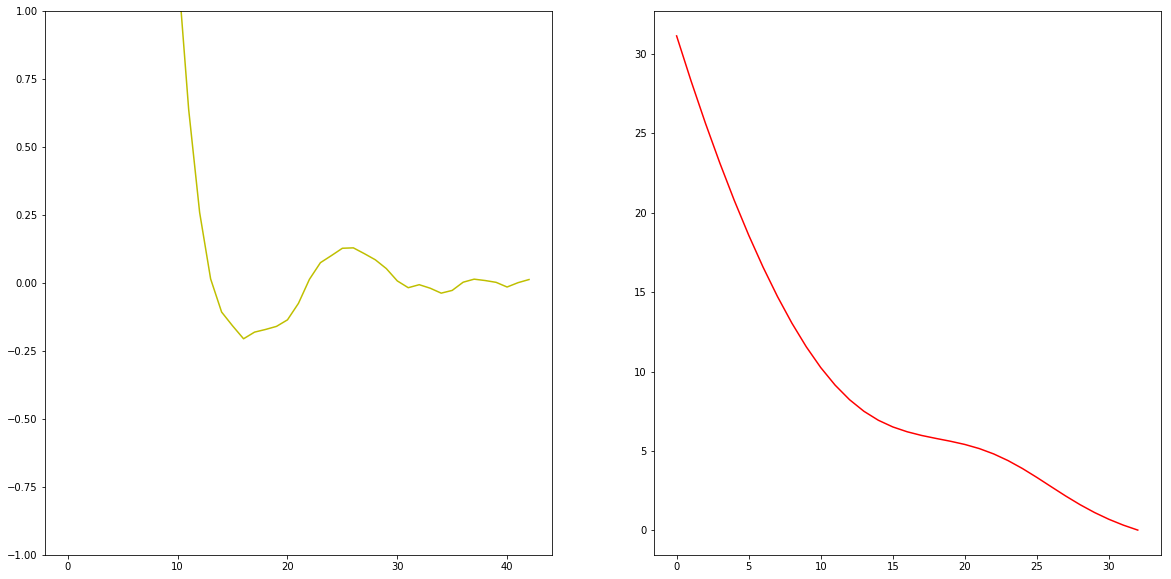

In [236]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
#axs[0].set_xlim(10,)
axs[0].set_ylim(-1.0,1.0)

axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

# plt.ylim(-2,10)
# plt.hlines(0, 0, 42)
# plt.legend()


# rr = np.linspace(1.3, 5.65, 436)

# plt.plot(rr, [make_bspline(b_all[1:1+len(pair_knots)], p_knot, r) for r in rr])
# plt.xlim(1.3,)
# plt.ylim(-1.5,0.2)
# plt.xlim(rr[0], rr[-1])
# plt.hlines(0.0, rr[0], rr[-1])

In [237]:
bounds

[slice(0, 200, 1),
 slice(200, 346, 1),
 slice(346, 472, 1),
 slice(472, 708, 1),
 slice(708, 841, 1),
 slice(841, 977, 1),
 slice(977, 1176, 1),
 slice(1176, 1267, 1),
 slice(1267, 1389, 1),
 slice(1389, 1394, 1),
 slice(1394, 1406, 1),
 slice(1406, 1412, 1),
 slice(0, 1612, 1)]

[-1139.195, 0.0, -1136.467, -1136.758, -1190.362, -1127.208]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


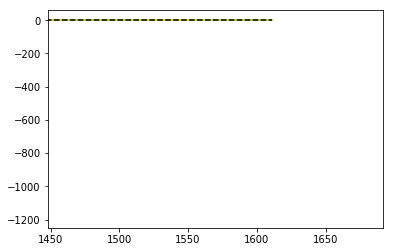

In [238]:
plt.plot(energy(b_all, X), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
plt.xlim(1448,)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2]]])

#print([round(z, 3) for z in y[-6:]])

[-1139.195, 0.0, -1136.467, -1136.758, -1190.362, -1127.208]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


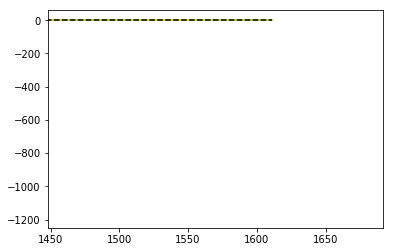

In [239]:
plt.plot(energy(b_all, X), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
plt.xlim(1448,)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2]]])

#print([round(z, 3) for z in y[-6:]])

In [240]:
print(bounds[:]), len(X[0])

[slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1394, 1), slice(1394, 1406, 1), slice(1406, 1412, 1), slice(0, 1612, 1)]


(None, 1612)

In [241]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [242]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    #X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1390, 1), slice(1390, 1395, 1), slice(1395, 1403, 1), slice(1403, 1413, 1), slice(1413, 1425, 1), slice(1425, 1431, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [243]:
energy(b_all, Xallx)[bounds[-2]]

array([-1139.19469834, -1127.76339293, -1115.50260367, -1099.86282736,
       -1083.25440452, -1076.52258004, -1079.13449224, -1085.51247701,
       -1091.79103002, -1094.68578158, -1083.42329901, -1072.38603304])

In [244]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(329.92519537914114, 96)

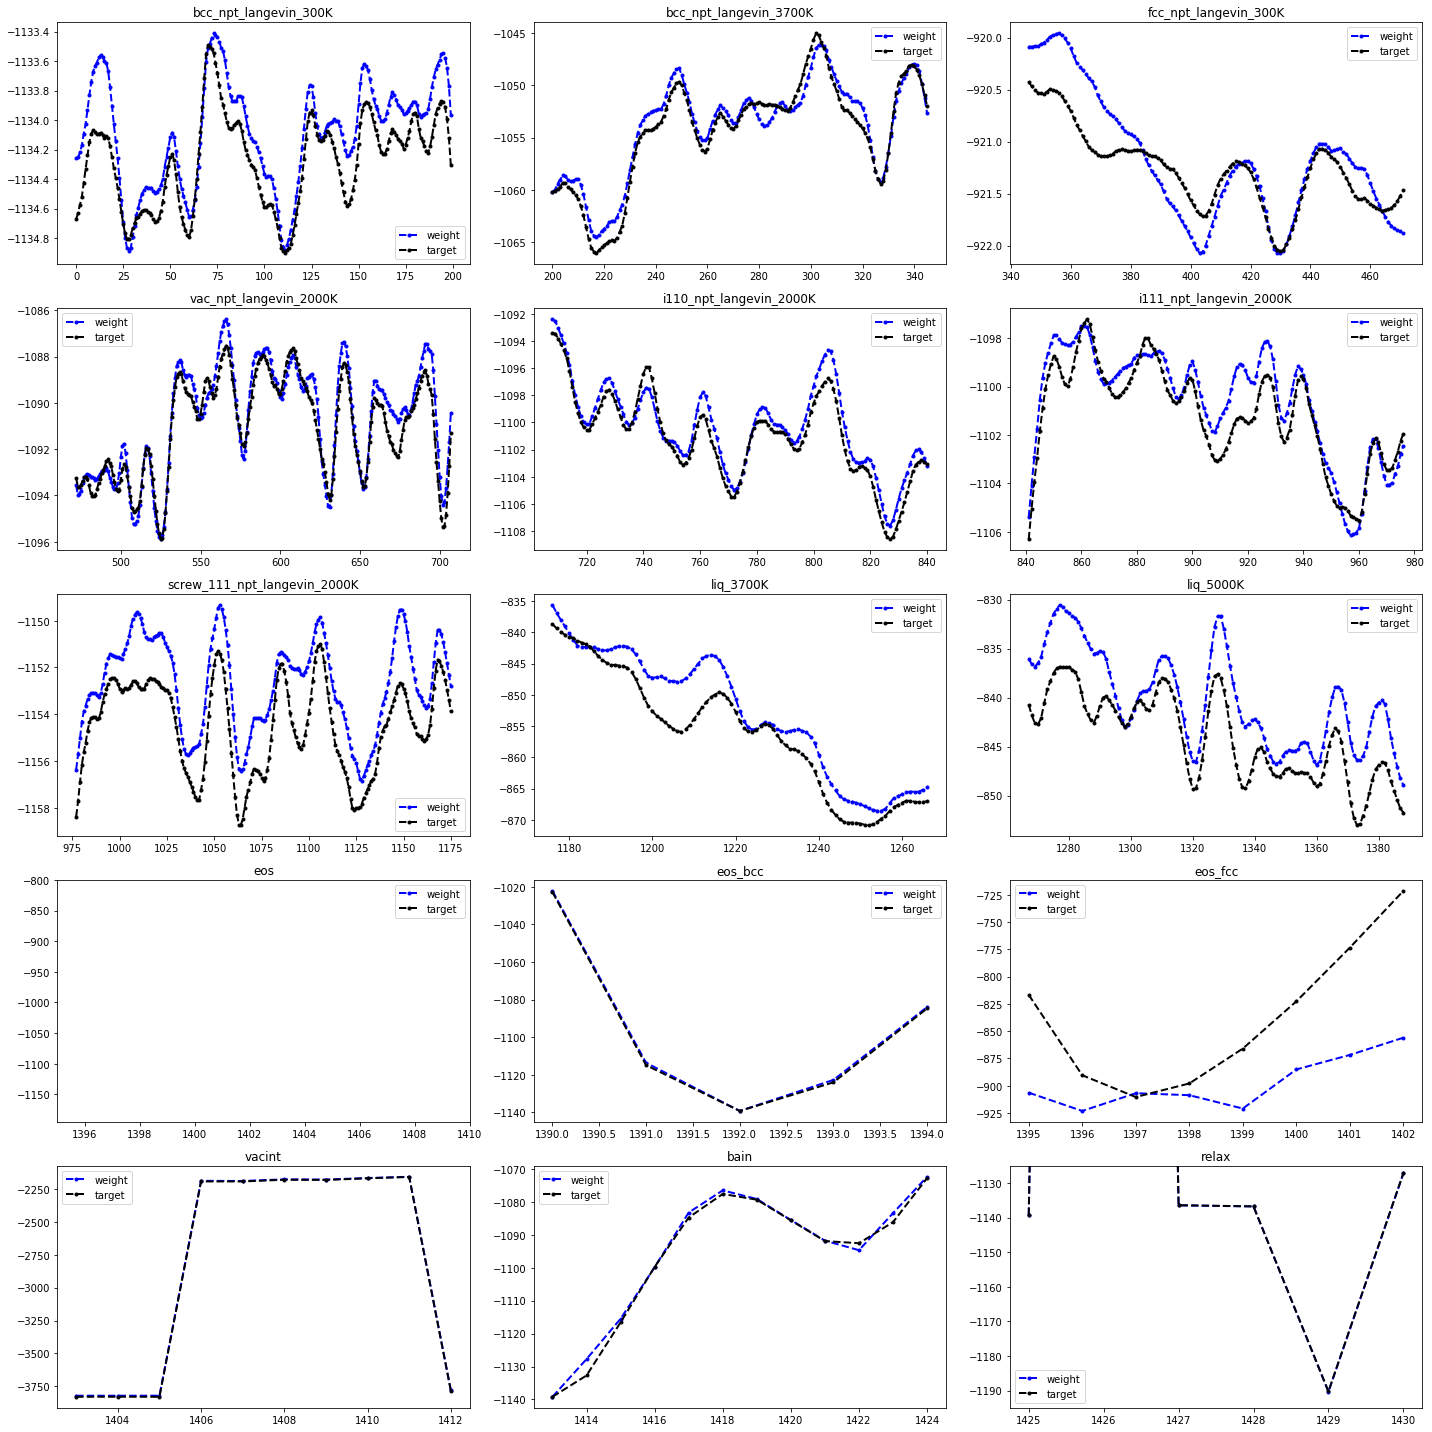

In [245]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(len(Xallx[0])))[bounds[k]][:]
    #print(rr)

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(b_all, Xallx)[bounds[k]][:], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [167]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [168]:
len(stats_tpfx['relax']['energy'][0][2]), len(stats_bsplinex['relax']['energy'][0][2])

(50, 46)

In [169]:
for key in targets.keys():
    targetsx[key]['weight'] = 1.0

In [170]:
# mb_knots = list(np.linspace(3.75, 5.25, 16))
# pair_knots = list(np.linspace(1.05, 5.25, 43))
# #pair_knots = list(np.linspace(2.05, 5.25, 33))

# print(mb_knots)
# print(pair_knots)

# # Select knots for optimization
# # cycle over knots of selected models
# stats_listx = []
# for knot in mb_knots:
#     edens_knots = [knot]
#     stats = downselect(stats_bsplinex, pair_knots, edens_knots)
#     stats_listx.append(stats)

In [172]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.25, 33))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [173]:
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)

bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


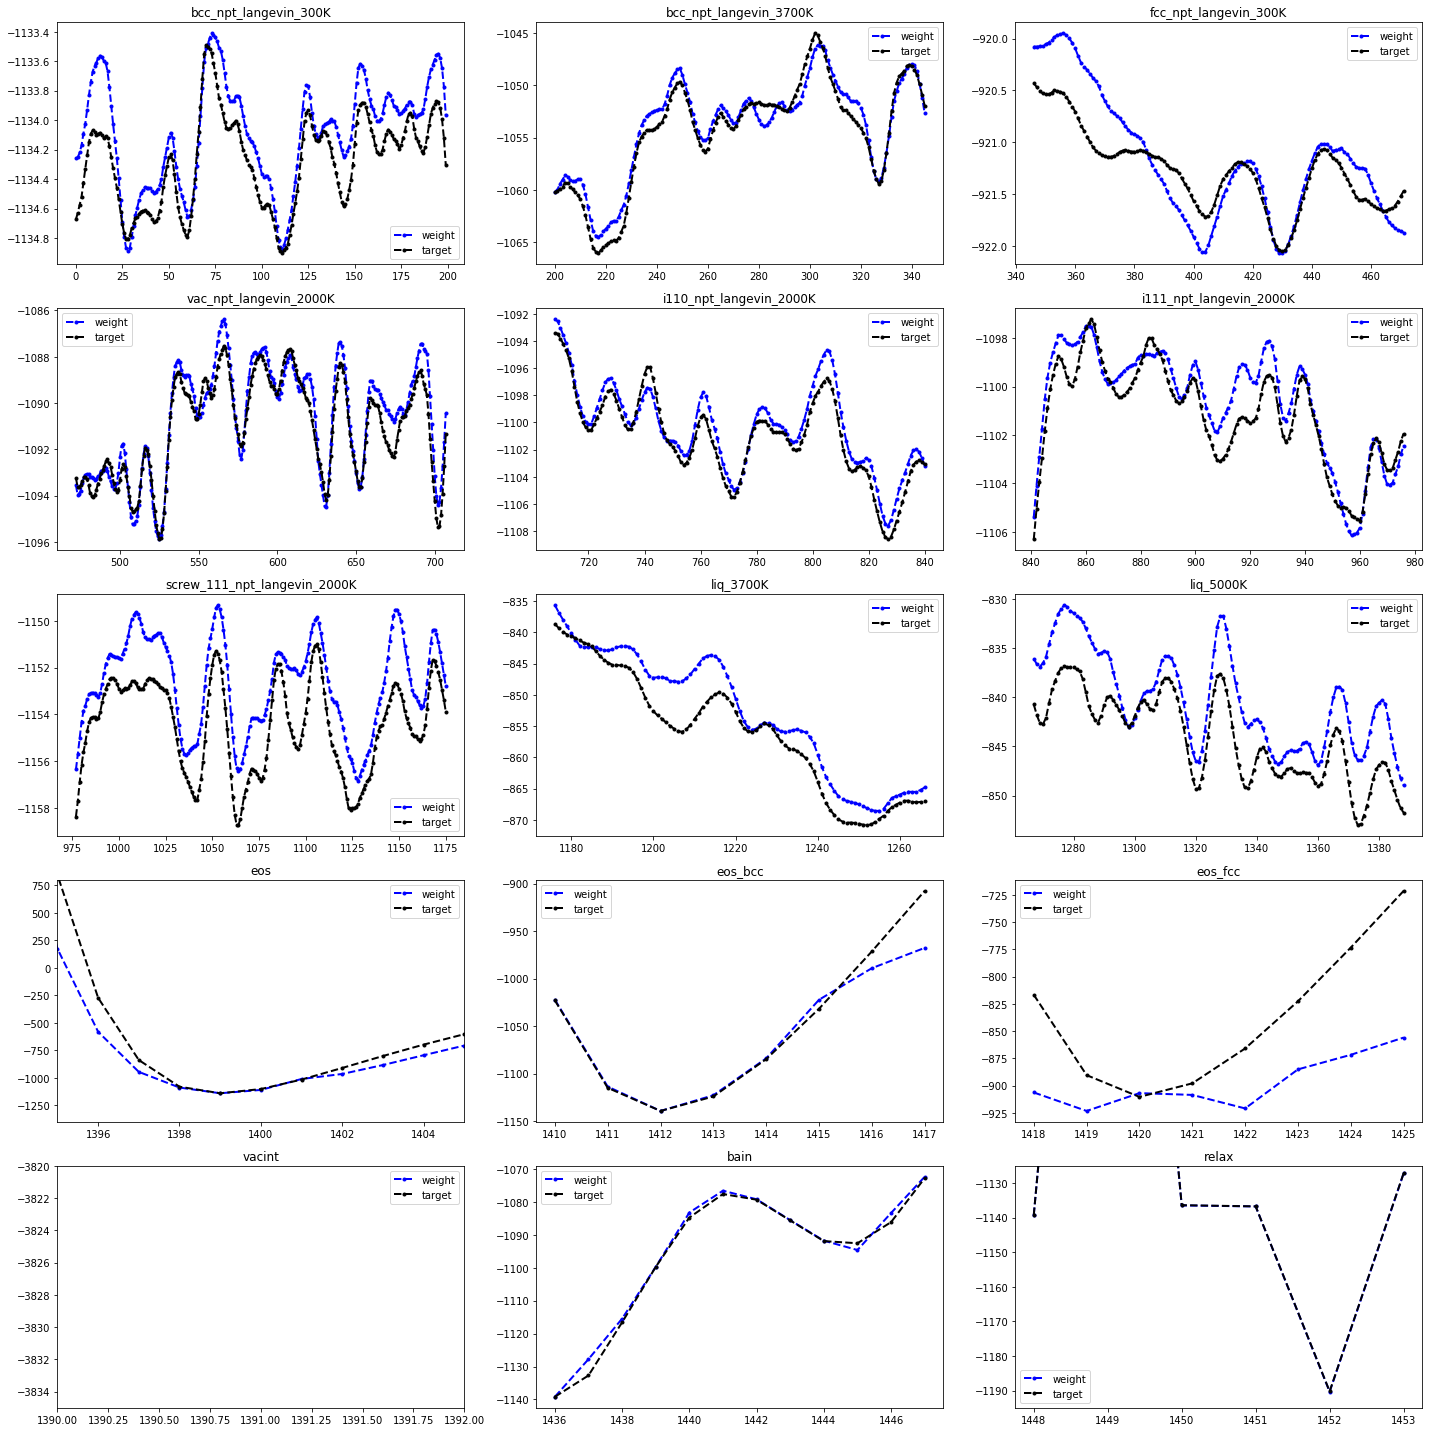

In [174]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(len(Xall[0])))[bounds[k]][:]

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='weight')

    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')
    axes[i,j].plot(rr, yall[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1400, 800)
        axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [181]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65]


In [182]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [183]:
M = _bspline_coeffs_to_tpf(43)

In [184]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 2.55353445e+03  2.19443545e+03  1.86215325e+03  1.55695649e+03
  1.27922489e+03  1.02943722e+03  8.07982985e+02  6.14420190e+02
  4.47812719e+02  3.07585586e+02  1.93736767e+02  1.06220159e+02
  4.32395751e+01  2.53996336e+00 -1.78027983e+01 -2.62741113e+01
 -3.42055175e+01 -3.00760587e+01 -2.85168816e+01 -2.65910022e+01
 -2.25996597e+01 -1.24850979e+01  2.28476126e+00  1.23655612e+01
  1.68820327e+01  2.12881910e+01  2.15063724e+01  1.79171998e+01
  1.42017022e+01  8.84177371e+00  1.29340973e+00 -2.88452714e+00
 -1.03113081e+00 -3.20148558e+00 -6.19533618e+00 -4.55208608e+00
  4.82664725e-01  2.35241532e+00  1.52659265e+00  4.03815315e-01
 -2.46080918e+00  2.03190244e-01  2.12221365e+00]
[ 2.55353445e+03 -8.01970235e+03  8.40561815e+03 -2.93918161e+03
  1.11080000e-01  9.90500000e-02 -8.92650000e-02 -8.31500000e-01
 -4.94121000e-01  3.61130000e-01  5.72962000e-01 -4.40790000e-02
 -1.75008390e+00 -4.58865040e-01  3.30929860e-01 -6.56127934e+00
 -2.84614044e+00  2.28525001e+01 -2.6152

In [188]:
Medens = _bspline_coeffs_to_tpf(33)

In [189]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[5.19233405e+03 4.71946170e+03 4.27401500e+03 3.85565263e+03
 3.46406873e+03 3.09936763e+03 2.76221900e+03 2.45372630e+03
 2.17448025e+03 1.92538953e+03 1.70789895e+03 1.52312667e+03
 1.37072540e+03 1.24905016e+03 1.15504132e+03 1.08495911e+03
 1.03380181e+03 9.95329849e+02 9.64052003e+02 9.34356013e+02
 9.00461328e+02 8.57152261e+02 8.00934908e+02 7.30721258e+02
 6.47476529e+02 5.53889002e+02 4.55582549e+02 3.58452363e+02
 2.67336642e+02 1.85398757e+02 1.14089439e+02 5.29862588e+01
 1.21587811e+00]
[ 5.19233405e+03 -1.60498745e+04  1.65501725e+04 -5.69297337e+03
  3.54600000e-02  4.10190000e-01  5.65340000e-01  4.33790000e-01
 -5.12740000e-01  3.17960000e-01  5.36130000e-01 -3.26650000e-01
 -1.46545000e+00 -1.29769000e+00 -1.41465000e+00 -6.80140000e-01
 -1.26195000e+00 -1.23785100e+00  7.48347000e-01 -1.21035000e-01
 -1.68292000e-01  5.64864000e-01  1.72178300e+00  2.40589300e+00
  2.05322900e+00  1.72306300e+00  2.93559100e+00  2.71321000e-01
 -1.05699500e+00 -1.67482700e+00 -1.7126

In [190]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

47 47
37 37


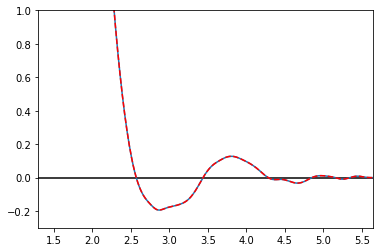

In [191]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

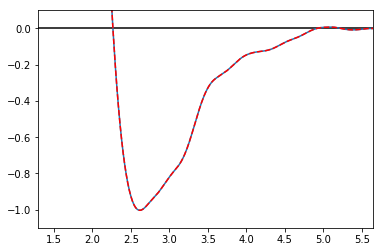

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01